In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd

### Reading CSV files into Dataframes

In [104]:
path = "..\\data\\processed"

MatchEventInfo = pd.read_csv(f"{path}\\MatchEventInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
PeriodInfo = pd.read_csv(f"{path}\\PeriodInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
MatchVotesInfo = pd.read_csv(f"{path}\\MatchVotesInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchTournamentInfo = pd.read_csv(f"{path}\\MatchTournamentInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchSeasonInfo = pd.read_csv(f"{path}\\MatchSeasonInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchRoundInfo = pd.read_csv(f"{path}\\MatchRoundInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchVenueInfo = pd.read_csv(f"{path}\\MatchVenueInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchHomeTeamInfo = pd.read_csv(f"{path}\\MatchHomeTeamInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchAwayTeamInfo = pd.read_csv(f"{path}\\MatchAwayTeamInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchHomeScoreInfo = pd.read_csv(f"{path}\\MatchHomeScoreInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchAwayScoreInfo = pd.read_csv(f"{path}\\MatchAwayScoreInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
MatchTimeInfo = pd.read_csv(f"{path}\\MatchTimeInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates(subset=['match_id'], keep='first')
GameInfo = pd.read_csv(f"{path}\\GameInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
OddsInfo = pd.read_csv(f"{path}\\OddsInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
PowerInfo = pd.read_csv(f"{path}\\PowerInfo.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()

I want to group matches that have started or were not canceled. I consider a match to have started if at least one period has a non-null value.

In [105]:
sets = ['period_1','period_2','period_3','period_4','period_5']
started_games = MatchTimeInfo['match_id'][MatchTimeInfo[sets].notna().any(axis=1)]
started_games

0        12260075
1        12260076
2        12260077
3        12260078
4        12260080
           ...   
19668    12384789
19669    12384806
19670    12384892
19671    12384975
19672    12385017
Name: match_id, Length: 5660, dtype: int64

We can write a function to fill null values of a daraframe column based on other column.

In [106]:
def fill_na(df, reference_column, target_column):
    '''
    Fills null values in the target_column based on the values in the reference_column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns.
    reference_column (str): The name of the column used to identify groups for filling nulls.
    target_column (str): The name of the column where null values will be filled.

    Returns:
    pd.DataFrame: DataFrame with nulls in target_column filled based on reference_column.

    '''
    df = df.reset_index(drop=True)

    # Selecting values of the using column in which rows that needed column is null.
    null_references = df[reference_column][df[target_column].isna()]

    isnull = df[(df[reference_column].isin(null_references)) & (df[target_column].isna())]
    notnull = df[(df[reference_column].isin(null_references)) & (df[target_column].notna())].drop_duplicates(subset=[reference_column], keep='first')

    mapping_index = notnull.set_index(reference_column)[target_column]
    isnull.loc[:,target_column] = isnull[reference_column].map(mapping_index)

    df.update(isnull)

    return df

## 1. How many tennis players are included in the dataset?

In [107]:
# Adding a new column to the data frames to indicate whether the player is home/away.
MatchHomeTeamInfo['pos'] = 'home'
MatchAwayTeamInfo['pos'] = 'away'

both_teams = pd.concat([MatchHomeTeamInfo, MatchAwayTeamInfo])
print(f"There are {both_teams['player_id'].unique().size} tennis players in the dataset.")

There are 2352 tennis players in the dataset.


## 2. What is the average height of the players?

In [109]:
null_heights = both_teams[both_teams['height'].isna()].shape[0]
print(f"There are {null_heights} null height values.")

There are 6002 null height values.


First I want to fill null heights based on other matches of the player.

In [25]:
both_teams = fill_na(both_teams,'player_id','height')
null_heights = both_teams[both_teams['height'].isna()].shape[0]
print(f"There are {null_heights} null height values.")

There are 5991 null height values.


Next, I want to fill in the null genders to fill other null heights based on gender.

In [26]:
# Filling each null 'gender' value with the gender of same 'match_id'. 
both_teams = fill_na(both_teams,'match_id','gender')

# Filling each null 'gender' value with the gender of same 'player_id'.
both_teams = fill_na(both_teams,'player_id','gender')
null_genders = both_teams[both_teams['gender'].isna()].shape[0]
print(f"There are {null_genders} null gender values.")

There are 0 null gender values.


Then I want to fill null heights based on the **Median** of the heights of each gender.

In [27]:
notnull_height = both_teams[(both_teams['height'].notna())]
mean_gender_height = notnull_height.groupby('gender')['height'].agg('median')
gender_fill_female = mean_gender_height.iloc[0]
gender_fill_male = mean_gender_height.iloc[1]

In [28]:
both_teams.loc[(both_teams['gender']=='M'),'height'] = both_teams.loc[(both_teams['gender']=='M'),'height'].fillna(gender_fill_male)
both_teams.loc[(both_teams['gender']=='F'),'height'] = both_teams.loc[(both_teams['gender']=='F'),'height'].fillna(gender_fill_female)

In [29]:
null_heights = both_teams[both_teams['height'].isna()].shape[0]
print(f"There are {null_heights} null height values.")

There are 0 null height values.


In [30]:
# Checking if a player has multiple values for their height.
duplicate_heights = both_teams.groupby('player_id')['height'].nunique()
players_with_multiple_heights = duplicate_heights[duplicate_heights > 1].index

inconsistent_players = both_teams[both_teams['player_id'].isin(players_with_multiple_heights)]
print(f"player_id {inconsistent_players['player_id'].unique()} has/have multiple values for their height.")

player_id [192862] has/have multiple values for their height.


So I want to change the inconsistency into the average of two values.

In [31]:
avg_height_192862 = both_teams['height'][both_teams['player_id']==192862].unique().mean()
both_teams.loc[(both_teams['player_id']==192862),'height'] = avg_height_192862

In [32]:
total_height = both_teams[['player_id','full_name','height','gender']].drop_duplicates(subset=['player_id'])
height_mean = np.mean(total_height['height'])
print(f"The players have the average height of {round(height_mean,2)}(m).")

The players have the average height of 1.79(m).


In [33]:
tallest_player = total_height.sort_values(by='height', ascending=False).iloc[0]
print(f"{tallest_player['full_name']} is the tallest player in the dataset {tallest_player['height']}(m).")

Vavassori, Andrea is the tallest player in the dataset 2.08(m).


In [34]:
shortest_player = total_height.sort_values(by='height', ascending=True).iloc[0]
print(f"{shortest_player['full_name']} is the shortest player in the dataset {shortest_player['height']}(m).")

Davis, Lauren is the shortest player in the dataset 1.57(m).


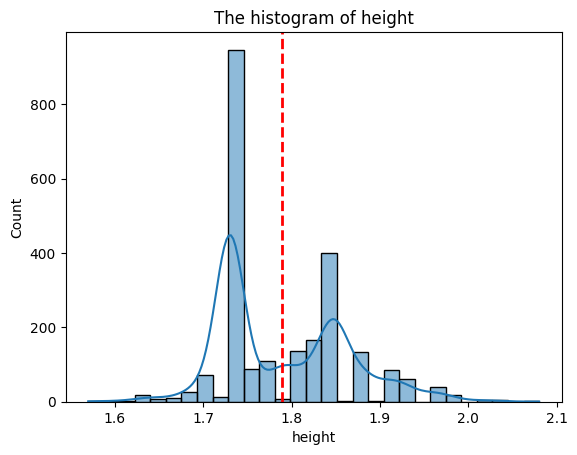

In [35]:
sns.histplot(total_height['height'], kde=True)
plt.axvline(height_mean, color='red', linestyle='dashed', linewidth=2)
plt.title("The histogram of height")
plt.show()

## 3. Which player has the highest number of wins?

In [36]:
# Assuming each match_id that has been repeated twice has two players and the match was not canceled.
count_matches = both_teams['match_id'].value_counts()

# Not considering matches that didn't start or for any reason were canceled. So I filter them using only started games.
filtered_players = both_teams[(both_teams['match_id'].isin(count_matches[count_matches == 2].index)) & (both_teams['match_id'].isin(started_games))]
filtered_players = filtered_players.sort_values(by='match_id')
# filtered_players

In [37]:
games = pd.merge(MatchEventInfo, filtered_players, on='match_id')

# Identifying home/away winners using the new 'pos' column and winner_code.
home_winners = games[(games['winner_code'] == 1) & (games['pos'] == 'home')]
away_winners = games[(games['winner_code'] == 2) & (games['pos'] == 'away')]

# counting each player's wins
away_wins_count = away_winners.groupby(['player_id','full_name'])['match_id'].agg('count')
home_wins_count = home_winners.groupby(['player_id','full_name'])['match_id'].agg('count')

# add home and away wins of each player.
all_wins = away_wins_count.add(home_wins_count, fill_value=0).reset_index(name='total_wins')
all_wins['total_wins'] = all_wins['total_wins'].astype(int)
all_wins = all_wins.sort_values(by='total_wins', ascending=False)
all_wins.head()

,player_id,full_name,total_wins
904,253356,"Uchijima, Moyuka",17
915,255428,"Back, Dayeon",13
292,88310,"Sherif, Mayar",12
520,163438,"Sun, Fajing",12
449,137948,"Chang, Hanna",12


In [38]:
most_won_player = all_wins.iloc[0]['full_name']
number_of_wins = all_wins.iloc[0]['total_wins']

print(f"{most_won_player} has won {number_of_wins} matches.")

Uchijima, Moyuka has won 17 matches.


## 4. What is the longest match recorded in terms of duration?

Also in this question, I only consider games that were not canceled.

In [39]:
sets = ['period_1','period_2','period_3','period_4','period_5']
filtered_times = MatchTimeInfo[MatchTimeInfo['match_id'].isin(started_games)]

match_durations = filtered_times.groupby('match_id')[sets].agg('sum').sum(axis=1).reset_index(name='total_time')
match_durations = match_durations.sort_values(by='total_time', ascending=False)
match_durations['total_time'] = pd.to_timedelta(match_durations['total_time'], unit='s')
match_durations.head()

,match_id,total_time
4313,12346747,1 days 23:32:33
837,12300269,1 days 21:50:40
3419,12336297,1 days 21:11:44
4763,12357962,1 days 19:01:17
2881,12330588,1 days 14:14:00


In [40]:
longest_match = match_durations.iloc[0]['match_id']
longest_match_time = match_durations.iloc[0]['total_time']

print(f"The longest match was {longest_match} and the duration was {longest_match_time}")

The longest match was 12346747 and the duration was 1 days 23:32:33


## 5. How many sets are typically played in a tennis match?

Also in this question, I only consider games that were not canceled.

In [41]:
filtered_times = MatchTimeInfo[MatchTimeInfo['match_id'].isin(started_games)]
match_sets = filtered_times.groupby('match_id')[sets].agg('count').sum(axis=1).reset_index(name='not_null_sets')

In [42]:
avg_sets_played = round(np.mean(match_sets['not_null_sets']))
print(f"Apart of the games that didn't start, there's usually {avg_sets_played} sets played in a tennis game")

Apart of the games that didn't start, there's usually 2 sets played in a tennis game


In [43]:
# Counting matches with 1 to 5 sets
p = match_sets.groupby('not_null_sets').agg('count').reset_index()
p.columns = ['number_of_sets','count']

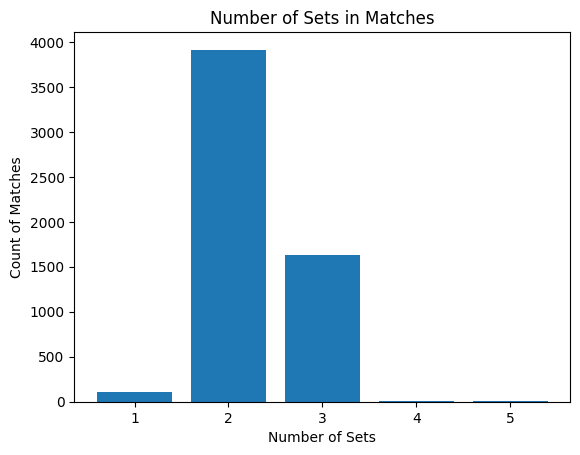

In [44]:
plt.bar(p['number_of_sets'], p['count'])
plt.title("Number of Sets in Matches")
plt.xlabel("Number of Sets")
plt.ylabel("Count of Matches")
plt.show()

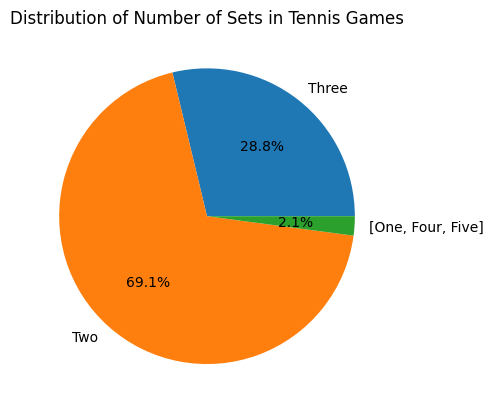

In [45]:
p['number_of_sets'] = ['One', 'Two', 'Three', 'Four', 'Five']
p['percentage'] = (p['count'] / p['count'].sum()) * 100

# Combining matches with a percentage of less than 20
p['labels_combined'] = p['number_of_sets'].where(p['percentage'] >= 20, '[One, Four, Five]')
p_combined = p.groupby('labels_combined')['count'].agg('sum').reset_index()

plt.pie(p_combined['count'], labels=p_combined['labels_combined'], autopct='%1.1f%%')
plt.title("Distribution of Number of Sets in Tennis Games")
plt.show()


## 6. Which country has produced the most successful tennis players?

First I want to count total wins of each country.

In [46]:
# Counting each win of every country from home or away.
home_wins_country = home_winners.groupby(['country'])['match_id'].agg('count')
away_wins_country = away_winners.groupby(['country'])['match_id'].agg('count')

# Adding each countries wins from home and away.
winner_country = home_wins_country.add(away_wins_country, fill_value = 0).reset_index(name='total_wins')
winner_country['total_wins'] = winner_country['total_wins'].astype(int)
winner_country = winner_country.sort_values(by='total_wins', ascending=False)
winner_country.head(10)

,country,total_wins
79,USA,362
26,France,295
37,Italy,285
40,Japan,252
28,Germany,183
67,Russia,176
2,Argentina,154
13,China,151
3,Australia,149
73,Spain,142


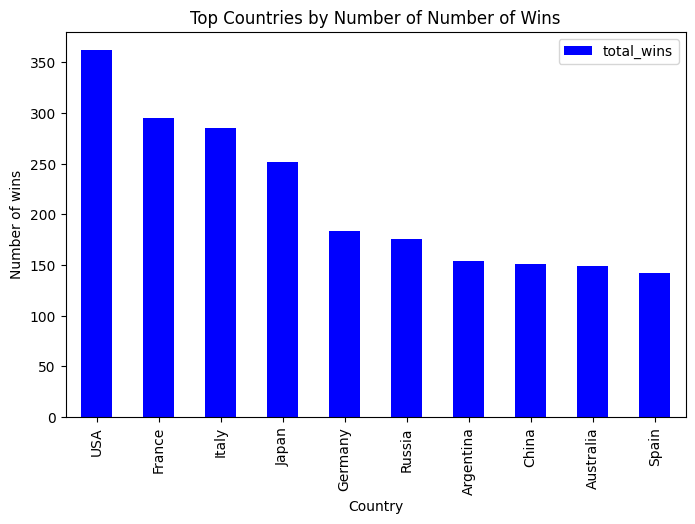

In [47]:
winner_country.head(10).plot.bar(x='country', y='total_wins', figsize=(8, 5), color='blue') 
plt.title("Top Countries by Number of Number of Wins")
plt.xlabel("Country")
plt.ylabel("Number of wins")
plt.show()

In [48]:
world = gpd.read_file('..\\references\\ne_110m_admin_0_countries.shp')

# Making sure countries match in map and winner_country dataframes
winner_country = winner_country.replace('USA','United States of America')
world_wins = pd.merge(world, winner_country.head(20), left_on='SOVEREIGNT', right_on='country')
world['total_wins'] = world['SOVEREIGNT'].map(winner_country.head(20).set_index('country')['total_wins']).fillna(0)

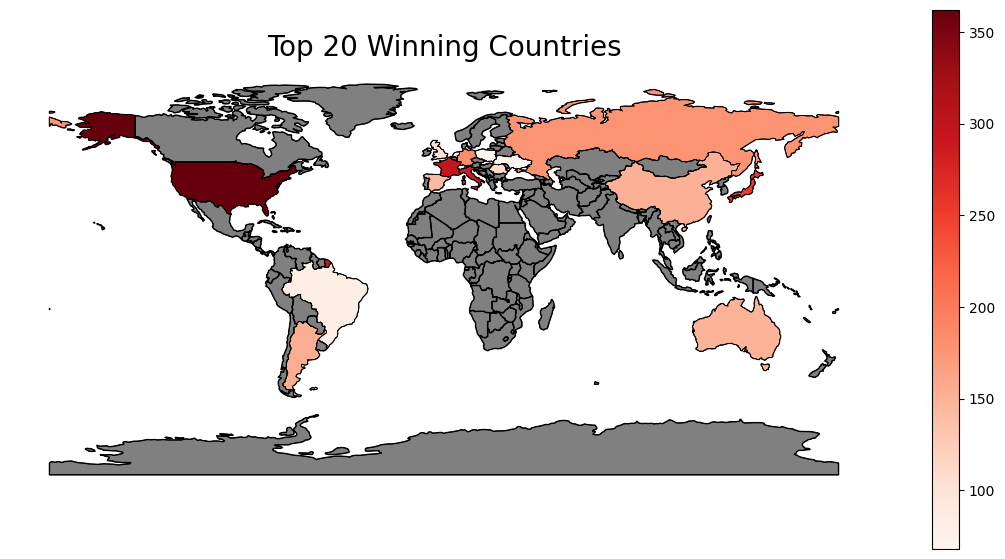

In [49]:
fig, ax = plt.subplots(figsize=(14, 7))

world.boundary.plot(ax=ax, linewidth=0.5, color='black')
world.plot(ax=ax, color='grey', edgecolor='black')

world[world['total_wins'] > 0].plot(column='total_wins', 
                              cmap='Reds',
                              linewidth=0.5,
                              edgecolor='black',
                              ax=ax,
                              legend=True)

ax.set_title("Top 20 Winning Countries", fontdict={'fontsize': 20})
ax.axis('off')
plt.show()

Now I want to count each player that won for each country.

In [50]:
# Counting the number of unique players who have won matches at home or away for each country.
home_winners_country = home_winners.groupby('country')['player_id'].nunique()
away_winners_country = away_winners.groupby('country')['player_id'].nunique()

# Adding the unique players from home and away.
unique_winners_country = home_winners_country.add(away_winners_country, fill_value=0).reset_index(name='unique_players')
unique_winners_country['unique_players'] = unique_winners_country['unique_players'].astype(int)
unique_winners_country = unique_winners_country.sort_values(by='unique_players', ascending=False)
unique_winners_country.head(10)

,country,unique_players
79,USA,181
37,Italy,160
26,France,146
40,Japan,121
67,Russia,105
28,Germany,96
73,Spain,78
2,Argentina,72
13,China,68
3,Australia,68


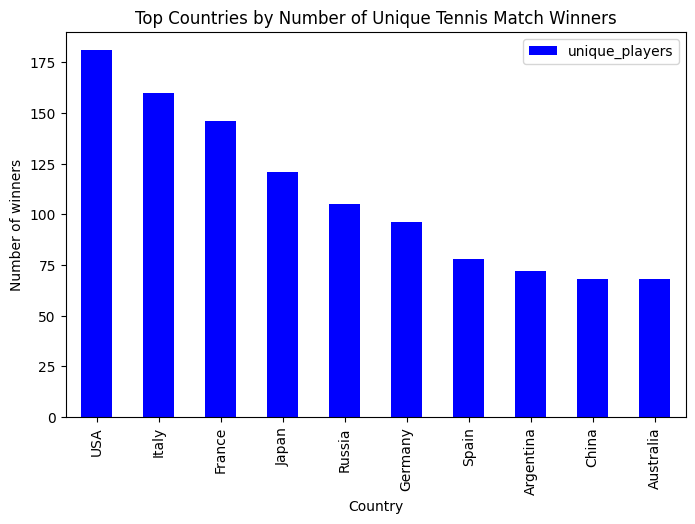

In [51]:
unique_winners_country.head(10).plot.bar(x='country', y='unique_players', figsize=(8, 5), color='blue') 
plt.title("Top Countries by Number of Unique Tennis Match Winners")
plt.xlabel("Country")
plt.ylabel("Number of winners")
plt.show()

## 7. What is the average number of aces per match?

In [52]:
filtered_periods = PeriodInfo[PeriodInfo['match_id'].isin(started_games)]

# Filtering match_id s which have aces as their statistic and represent the entire game (period = ALL).
total_aces = filtered_periods[(filtered_periods['statistic_name']=='aces') & (filtered_periods['period'] == 'ALL')]\
    .drop_duplicates(subset=['match_id'], keep='first')
total_aces['all_aces'] = total_aces['home_stat'].astype(int).add(total_aces['away_stat'].astype(int))
total_aces = total_aces[['match_id','all_aces']].sort_values(by='all_aces', ascending=False)
total_aces.head()

,match_id,all_aces
556709,12337573,37
237642,12320545,30
505997,12346238,30
513666,12349399,30
483640,12346136,28


In [53]:
avg_aces_per_match = np.mean(total_aces['all_aces'])
print(f"The average number of aces per match is {round(avg_aces_per_match)}.")

The average number of aces per match is 4.


In [54]:
Q1 = np.percentile(total_aces['all_aces'], 25)
Q2 = np.percentile(total_aces['all_aces'], 50)
Q3 = np.percentile(total_aces['all_aces'], 75)
iqr = Q3 - Q1
upper = Q3+ 1.5*iqr
print(f"Q1:{Q1}, Q2:{Q2}, Q3:{Q3}, iqr:{iqr}, upper:{upper}")

Q1:1.0, Q2:3.0, Q3:6.0, iqr:5.0, upper:13.5


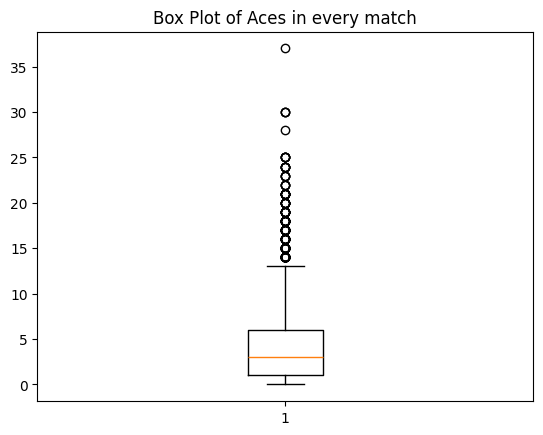

In [55]:
plt.boxplot(total_aces['all_aces'])
plt.title("Box Plot of Aces in every match")

plt.show()

## 8. Is there a difference in the number of double faults based on gender?

In [56]:
filtered_periods = PeriodInfo[PeriodInfo['match_id'].isin(started_games)]

# Filtering match_id s which have double_faults as their statistic and represent the entire game (period = ALL).
faults = filtered_periods[(filtered_periods['statistic_name'] == 'double_faults') & (filtered_periods['period'] == 'ALL')]\
    .drop_duplicates(subset=['match_id'], keep='first')

I only want to consider the matches that were mentioned in the **both_teams** data frame twice. So I use **filtered_players** as before.

In [57]:
# Creating a dataframe for each player's double faults.
all_fault = pd.merge(faults, filtered_players, on='match_id')

In [58]:
# Creating a column for each player and their faults.
all_fault['fault_count'] = all_fault['home_stat'].where(all_fault['pos'] == 'home', all_fault['away_stat'])
fault_gender = all_fault[['match_id','player_id','full_name','gender','fault_count']]
fault_gender.loc[:,'fault_count'] = fault_gender['fault_count'].astype(int)

In [59]:
count_gender_faults = fault_gender.groupby('gender')['fault_count'].agg('sum')
print(f"The number of female double-faults is {count_gender_faults.loc['F']} and male double-faults is {count_gender_faults.loc['M']}.")

The number of female double-faults is 14995 and male double-faults is 11645.


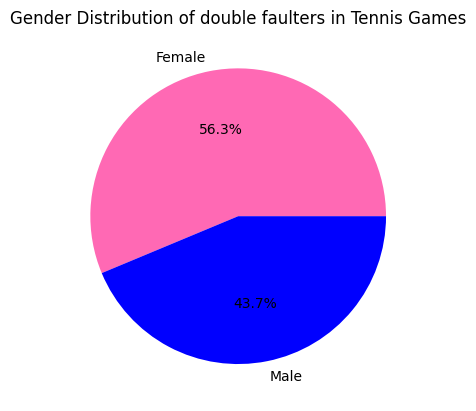

In [60]:
labels = ['Female', 'Male']
sizes = [count_gender_faults.loc['F'], count_gender_faults.loc['M']]
colors = ['hotpink', 'blue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Gender Distribution of double faulters in Tennis Games")
plt.show()

## 9. Which player has won the most tournaments in a single month?

In [61]:
# Merging home winners and  away winners to see which game was on which tournament.
home_tournament_winner = pd.merge(MatchTournamentInfo, home_winners, on='match_id')
away_tournament_winner = pd.merge(MatchTournamentInfo, away_winners, on='match_id')

home_tournament_winner = home_tournament_winner[['player_id','full_name','match_id','tournament_id']]
away_tournament_winner = away_tournament_winner[['player_id','full_name','match_id','tournament_id']]
all_tournament_winners = pd.concat([home_tournament_winner, away_tournament_winner]).sort_values(by='player_id')

In [62]:
number_of_tournaments_won = all_tournament_winners.groupby(['player_id','full_name'])['tournament_id'].agg('nunique')\
    .sort_values(ascending=False).reset_index()
most_won_tournamnets = number_of_tournaments_won.head(1)
print(f"{most_won_tournamnets['full_name'].iloc[0]} won {most_won_tournamnets['tournament_id'].iloc[0]} tournaments in May 2024.")

Kuramochi, Miho won 7 tournaments in May 2024.


In [63]:
number_of_tournaments_won

,player_id,full_name,tournament_id
0,390973,"Kuramochi, Miho",7
1,256104,"Volynets, Katie",6
2,158748,"Meligeni Alves, Felipe",5
3,235052,"Matsuda, Misaki",5
4,54903,"Karlovskiy, Evgeny",5
...,...,...,...
1455,478921,"Ye, Shiyu",1
1456,477600,"Sun, Yingqun",1
1457,476537,"Mpetshi Perricard, Daphnee",1
1458,475952,"Jansson, Oskar",1


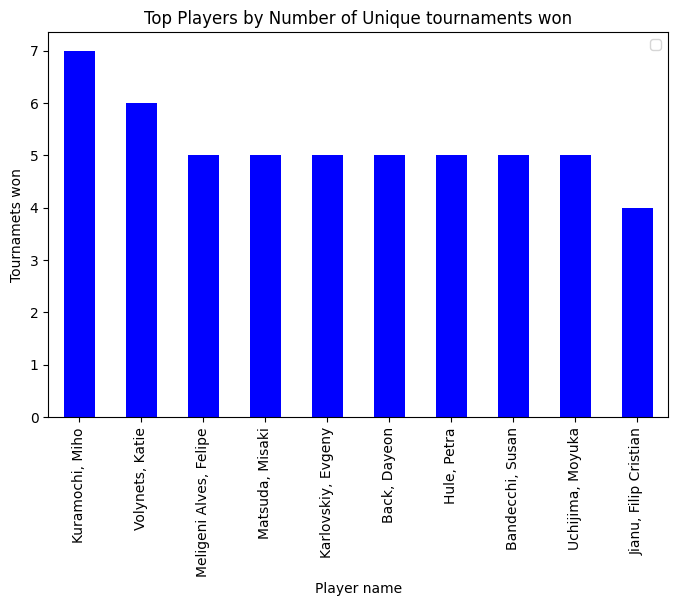

In [64]:
number_of_tournaments_won.head(10).plot.bar(x='full_name', y='tournament_id', figsize=(8, 5), color='blue') 
plt.title("Top Players by Number of Unique tournaments won")
plt.legend('')
plt.ylabel("Tournamets won")
plt.xlabel("Player name")

plt.show()

## 10. Is there a correlation between a player's height and their ranking?

In [65]:
non_null_data = both_teams[['player_id','height','current_rank']].dropna().sort_values(by='current_rank')\
    .drop_duplicates(subset=['player_id'], keep='first')

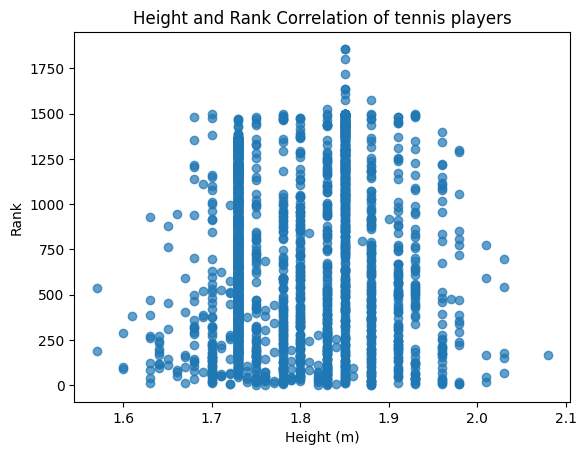

In [66]:
plt.scatter(non_null_data['height'], non_null_data['current_rank'], alpha=0.7)
plt.xlabel("Height (m)")
plt.ylabel("Rank")
plt.title("Height and Rank Correlation of tennis players")
plt.show()

The relationship between height and rank is non linear so I want to use spearman correlation test.

In [67]:
spearman_corr, _ = stats.spearmanr(non_null_data['height'], non_null_data['current_rank'])
print(spearman_corr)

0.015169554929001444


Based on Cohen's Guidelines from Jacob Cohen's book Statistical Power Analysis for the Behavioral Sciences (1988), We can rank the correlation into these categories:
- Large Correlation: ∣corr∣ ≥ 0.5
- Medium Correlation:  0.3 ≤ ∣corr∣ ≤ 0.5
- Small Correlation:  0 ≤ ∣corr∣ ≤ 0.3

In [68]:
if abs(spearman_corr) >= 0.5:
    print("There is a large correlation between height and rank of tennis players.")
elif abs(spearman_corr) >= 0.3:
    print("There is a medium correlation between height and rank of tennis players.")
else:
    print("There is a small correlation between height and rank of tennis players.")

There is a small correlation between height and rank of tennis players.


## 11. What is the average duration of matches?

In [69]:
match_average_duration = np.mean(match_durations['total_time']).round('s')
print(f"The average duration of matches is: {match_average_duration}")

The average duration of matches is: 0 days 01:59:20


## 12. What is the average number of games per set in men's matches compared to women's matches?

In [70]:
both_teams_game = pd.merge(GameInfo, both_teams, on='match_id')

# Finding number of games per set and match for each gender.
temp = both_teams_game.groupby(['match_id','set_id','gender'])['game_id'].agg('max').reset_index(name='game_count')

avg_game_per_set = temp.groupby(['gender','set_id'])['game_count'].agg('mean').round(2).unstack().fillna(0)
avg_game_per_set

set_id,1,2,3,4,5
gender,,,,,
F,9.07,8.93,8.47,0.00,0.0
M,9.36,9.20,8.75,9.53,10.1


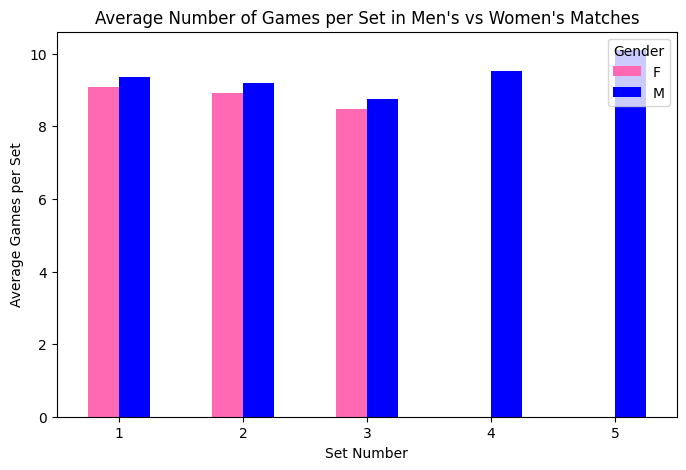

In [71]:
colors = ['hotpink','blue']
avg_game_per_set.T.plot(kind='bar', figsize=(8, 5), color=colors)
plt.xlabel("Set Number")
plt.ylabel("Average Games per Set")
plt.title("Average Number of Games per Set in Men's vs Women's Matches")
plt.legend(title="Gender")
plt.xticks(rotation=0)
plt.show()

## 13. What is the distribution of left-handed versus right-handed players?

In [72]:
null_plays = both_teams[both_teams['plays'].isna()]
print(f"There are {null_plays.shape[0]} null 'plays' values.")

There are 6704 null 'plays' values.


There are too many null values, so I decide to not fill them with their mode.

In [73]:
count_plays = both_teams.groupby('plays')['player_id'].agg('nunique').reset_index(name='count_players')
count_plays['percentage'] = ((count_plays['count_players'] / count_plays['count_players'].sum()) * 100).round(3)
count_plays

,plays,count_players,percentage
0,ambidextrous,1,0.097
1,left-handed,120,11.662
2,right-handed,908,88.241


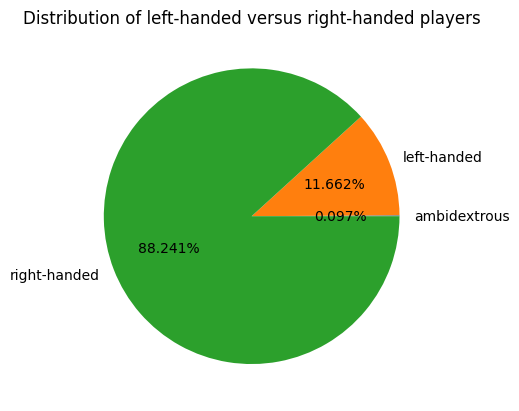

In [74]:
plt.pie(count_plays['percentage'], labels=count_plays['plays'], autopct='%1.3f%%')
plt.title("Distribution of left-handed versus right-handed players")
plt.show()

## 14. What is the most common type of surface used in tournaments?

First I want to check if every tournament match had the same ground type.

In [75]:
count_grounds = MatchTournamentInfo.groupby('tournament_id')['ground_type'].agg('nunique')

multi_ground_tournament = count_grounds[count_grounds > 1]

if multi_ground_tournament.empty:
    print("All tournaments had one ground type.")
    
else:
    print("Tournaments which had multiple ground types:")
    print(multi_ground_tournament)

Tournaments which had multiple ground types:
tournament_id
130937    2
130940    2
130955    2
130967    2
131015    2
Name: ground_type, dtype: int64


In [76]:
most_common_surface = MatchTournamentInfo['ground_type'].mode().loc[0]
print(f"The most common surface in tournaments is {most_common_surface}.")

The most common surface in tournaments is Red clay.


In [77]:
count_surface = MatchTournamentInfo.groupby('ground_type')['match_id'].agg('count').reset_index(name='count').sort_values(by='count')
count_surface['percentage'] = ((count_surface['count'] / count_surface['count'].sum()) * 100).round(2)
count_surface

,ground_type,count,percentage
3,Synthetic outdoor,47,0.51
0,Hardcourt indoor,122,1.32
1,Hardcourt outdoor,2295,24.81
2,Red clay,6787,73.37


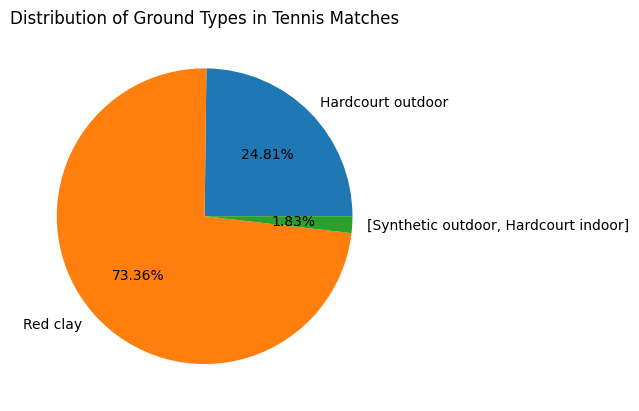

In [78]:
# Combining ground types with a percentage of less than 20% into a single label
count_surface['labels_combined'] = count_surface['ground_type'].where(count_surface['percentage'] >= 20, '[Synthetic outdoor, Hardcourt indoor]')
count_surface_combined = count_surface.groupby('labels_combined', as_index=False)['percentage'].agg('sum')

plt.pie(count_surface_combined['percentage'], labels=count_surface_combined['labels_combined'], autopct='%1.2f%%')
plt.title("Distribution of Ground Types in Tennis Matches")
plt.show()

## 15. How many distinct countries are represented in the dataset?

In [79]:
countries_in_dataset = pd.concat([both_teams['country'], MatchVenueInfo['country']]).unique()
print(f"There are {countries_in_dataset.size} countries in this dataset.")

There are 100 countries in this dataset.


## 16. Which player has the highest winning percentage against top 10 ranked opponents?

First I want to consider each players best rank in May 2024.

In [80]:
# Finding the top 10 players
players_ranks = both_teams.sort_values(by='current_rank', ascending=True).drop_duplicates(subset=['player_id'], keep='first')
top_ten_players = players_ranks[['player_id','full_name','current_rank']][players_ranks['current_rank'] <= 10]

# Finding matches that include top 10 players and have started.
top_ten_matches = both_teams[['match_id','player_id','full_name']]\
    [(both_teams['player_id'].isin(top_ten_players['player_id'])) & (both_teams['match_id'].isin(started_games))].drop_duplicates(subset=['match_id'])

# Finding players who are included in the top 10 matches.
players_against_top_ten = both_teams[['match_id','player_id','full_name']]\
    [both_teams['match_id'].isin(top_ten_matches['match_id'])].sort_values(by='match_id')

# Counting matches for each player that was in the top ten matches.
total_matches = players_against_top_ten.groupby(['player_id','full_name'])['match_id'].agg('count').reset_index(name='total_matches')

# Finding winners.
winners_rank = pd.concat([home_winners,away_winners])[['match_id','player_id','full_name']].sort_values(by='match_id')

# Finding winners of top matches.
winner_in_top_matches = winners_rank[winners_rank['match_id'].isin(top_ten_matches['match_id'])].sort_values(by='match_id')

# Creating a data frame for each top ten player who attended the match and the match's winner.
matches = pd.merge(top_ten_matches, winner_in_top_matches, on='match_id', suffixes=['','_winner'])

# Counting each player wins in the top ten matches.
win_count = matches.groupby(['player_id_winner','full_name_winner'])['match_id'].agg('count').reset_index(name='total_wins')

In [81]:
# Creating a data frame for each player and their winning percentage.
player_stats = pd.merge(total_matches, win_count, left_on='player_id', right_on='player_id_winner') 
player_stats['winning_percentage'] = (player_stats['total_wins'] / player_stats['total_matches']) * 100
player_stats = player_stats.sort_values(['total_wins', 'winning_percentage'], ascending=[False, False])
player_stats

,player_id,full_name,total_matches,player_id_winner,full_name_winner,total_wins,winning_percentage
29,228272,"Swiatek, Iga",9,228272,"Swiatek, Iga",9,100.000000
21,157754,"Sabalenka, Aryna",10,157754,"Sabalenka, Aryna",8,80.000000
6,57163,"Zverev, Alexander",8,57163,"Zverev, Alexander",7,87.500000
7,58515,"Collins, Danielle",9,58515,"Collins, Danielle",7,77.777778
33,264983,"Gauff, Cori",7,264983,"Gauff, Cori",6,85.714286
17,122366,"Tsitsipas, Stefanos",5,122366,"Tsitsipas, Stefanos",4,80.000000
0,14882,"Djokovic, Novak",6,14882,"Djokovic, Novak",4,66.666667
15,106755,"Rublev, Andrey",6,106755,"Rublev, Andrey",4,66.666667
16,119248,"Ruud, Casper",6,119248,"Ruud, Casper",4,66.666667
27,206570,"Sinner, Jannik",3,206570,"Sinner, Jannik",3,100.000000


In [82]:
top_player = player_stats.iloc[0]
print(f"Player with the highest winning percentage against top 10 ranked opponents:\
      \nPlayer_id: {top_player['player_id']}\nFull_name: {top_player['full_name']}\
      \n{top_player['winning_percentage']:.2f}% win of {top_player['total_wins']} matches.")

Player with the highest winning percentage against top 10 ranked opponents:      
Player_id: 228272
Full_name: Swiatek, Iga      
100.00% win of 9 matches.


In [83]:
non_top_player_stats = player_stats[~player_stats['player_id'].isin(top_ten_players['player_id'])]\
    .sort_values(['total_wins', 'winning_percentage'], ascending=[False, False])
top_non_top_ten_player = non_top_player_stats.iloc[0]
print(f"Player with the highest winning percentage against top 10 ranked opponents (excluding top 10 players):\
      \nPlayer_id: {top_non_top_ten_player['player_id']}\nFull_name: {top_non_top_ten_player['full_name']}\
      \n{top_non_top_ten_player['winning_percentage']:.2f}% win of {top_non_top_ten_player['total_wins']} matches.")

Player with the highest winning percentage against top 10 ranked opponents (excluding top 10 players):      
Player_id: 138546
Full_name: Paul, Tommy      
100.00% win of 2 matches.


In [84]:
non_top_player_stats

,player_id,full_name,total_matches,player_id_winner,full_name_winner,total_wins,winning_percentage
19,138546,"Paul, Tommy",2,138546,"Paul, Tommy",2,100.000000
4,35424,"Keys, Madison",4,35424,"Keys, Madison",2,50.000000
2,19728,"Cirstea, Sorana",1,19728,"Cirstea, Sorana",1,100.000000
10,88992,"Muller, Alexandre",1,88992,"Muller, Alexandre",1,100.000000
13,91960,"Kenin, Sofia",1,91960,"Kenin, Sofia",1,100.000000
26,198592,"Kecmanović, Miomir",1,198592,"Kecmanović, Miomir",1,100.000000
28,221012,"Cerundolo, Francisco",1,221012,"Cerundolo, Francisco",1,100.000000
32,262594,"Avanesyan, Elina",1,262594,"Avanesyan, Elina",1,100.000000
35,299538,"Arnaldi, Matteo",1,299538,"Arnaldi, Matteo",1,100.000000
1,19017,"Azarenka, Victoria",2,19017,"Azarenka, Victoria",1,50.000000


## 17. What is the average number of breaks of serve per match?

In [85]:
filtered_periods = PeriodInfo[PeriodInfo['match_id'].isin(started_games)]

# Filtering match_id s which have break_points_converted as their statistic and represent the entire game (period = ALL).
total_breaks = filtered_periods[(filtered_periods['statistic_name']=='break_points_converted') & (filtered_periods['period'] == 'ALL')]\
    .drop_duplicates(subset=['match_id'], keep='first')
total_breaks['all_breaks'] =  total_breaks['home_stat'].astype(int).add(total_breaks['away_stat'].astype(int))
total_breaks = total_breaks[['match_id','all_breaks']].sort_values(by='all_breaks', ascending=False)
total_breaks.head()

,match_id,all_breaks
162490,12312793,26
772251,12381559,23
269237,12325672,22
170481,12313749,21
30260,12298152,21


In [86]:
avg_breaks_per_match = np.mean(total_breaks['all_breaks'])
print(f"The average number of breaks per match is {round(avg_breaks_per_match)}.")

The average number of breaks per match is 7.


In [87]:
Q1_break = np.percentile(total_breaks['all_breaks'], 25)
Q2_break = np.percentile(total_breaks['all_breaks'], 50)
Q3_break = np.percentile(total_breaks['all_breaks'], 75)
iqr_break = Q3_break - Q1_break
upper_break = Q3_break + 1.5*iqr_break
print(f"Q1:{Q1_break}, Q2:{Q2_break}, Q3:{Q3_break}, iqr:{iqr_break}, upper:{upper_break}")

Q1:5.0, Q2:7.0, Q3:9.0, iqr:4.0, upper:15.0


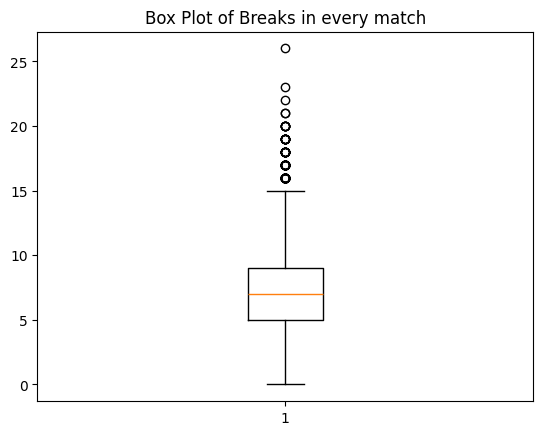

In [88]:
plt.boxplot(total_breaks['all_breaks'])
plt.title("Box Plot of Breaks in every match")

plt.show()